**In this Notebook we work on Titanic passengers database and make predictions on their survival. We use scikit-learn package, please feel free to learn classification in scikit from here https://scikit-learn.org/stable/supervised_learning.html#supervised-learning
Most of the functions needed for the homework are in the notebook, please look at the arguments for each function and play with them to improve your understanding**



# Data Importing

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')


# Data Exploration

**Explore the dataset by looking at the features. For improving the accuracy you can play with features as well, if you feel some of the features are not needed, you can drop them.**

In [2]:
# This is the top few elements of the training data. 
dftrain.head()

# We're gonna check all the features that are stored in the data. Note that the code above popped out the survived column,
# which is used as the y_train and y_eval. 
dftrain.keys()

Index(['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck',
       'embark_town', 'alone'],
      dtype='object')

I had to Google around to figure out what 'parch' was. Turns out it's the number of parents and children aboard the Titanic. 
Not sure why it's not formatted in something like 'n_parents_children', like the siblings and spouses are.

In [3]:
# This is the top few elements of the evaluation data. 
dfeval.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,male,54.0,0,0,51.8625,First,E,Southampton,y
2,female,58.0,0,0,26.5500,First,C,Southampton,y
3,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,male,34.0,0,0,13.0000,Second,D,Southampton,y


**Analyse the dataset, here you find the count, statistics of dataset**

In [4]:
# All the statistics of the training data that is number based. 
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


**Look at labeled data of both training and evaluation set**

In [5]:
# This tells you the top few elements of the associated labels for all the samples in the training data.
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [6]:
# This tells you the top few elements of the associated labels for all the samples in the evaluation data.
y_eval.head()

0    0
1    0
2    1
3    1
4    1
Name: survived, dtype: int64

**In the next few plots you can observe few more things in the dataset like distribution of age of passengers. Make good observations on the features, it might help you push your prediction accuracy**

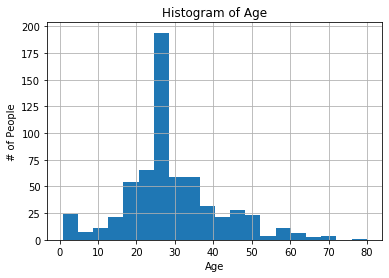

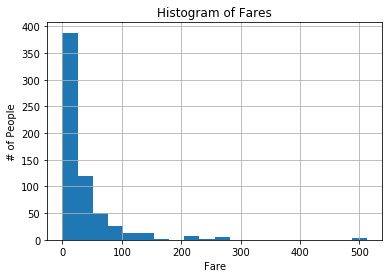

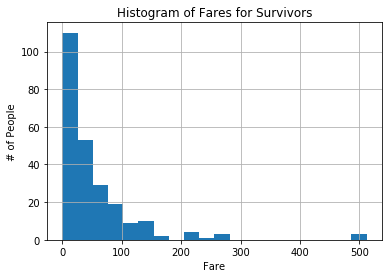

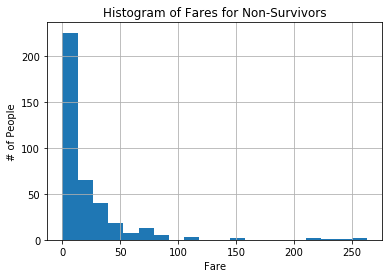

In [7]:
# Splits the age distribution into 20 bins, and plots them. 
dftrain.age.hist(bins=20)
plt.title('Histogram of Age')
plt.ylabel('# of People')
plt.xlabel('Age')
plt.show()

# It's also interesting to look at the fares; I suspect that besides women/children taking priority, richer customers 
# also got a higher priority. So I'll have to sort the data into survived and not survived, to see what the distribution
# is like.

# First we'll try it with the training data. 
df_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
# Then we sort it into two dataframes: one survived, and one not. 
df_survive = df_train.loc[df_train['survived'] == 1]
df_died = df_train.loc[df_train['survived'] == 0]

# Plotting fare histogram.
dftrain.fare.hist(bins=20)
plt.title('Histogram of Fares')
plt.ylabel('# of People')
plt.xlabel('Fare')
plt.show()

# Plotting survived histogram.
df_survive.fare.hist(bins=20)
plt.title('Histogram of Fares for Survivors')
plt.ylabel('# of People')
plt.xlabel('Fare')
plt.show()

# Plotting died histogram. 
df_died.fare.hist(bins=20)
plt.title('Histogram of Fares for Non-Survivors')
plt.ylabel('# of People')
plt.xlabel('Fare')
plt.show()

**Make some observations on the unfortundate :( data set**

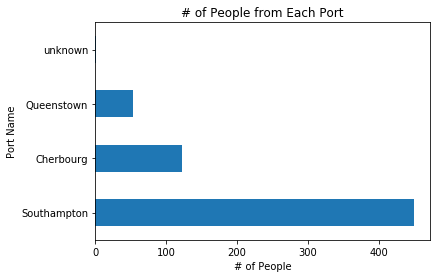

In [8]:
# Plotting the distribution of people from each port. 
dftrain.embark_town.value_counts().plot(kind='barh')
plt.title('# of People from Each Port')
plt.ylabel('Port Name')
plt.xlabel('# of People')
plt.show()

**Survived passengers for each class**

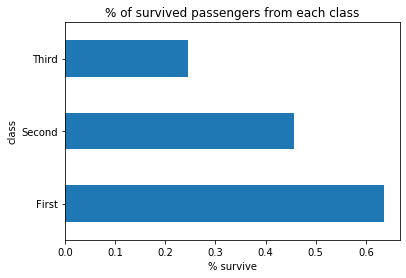

In [9]:
pd.concat([dftrain, y_train], axis=1).groupby('class').survived.mean().plot(kind='barh').set_xlabel('% survive')
plt.title('% of survived passengers from each class')
plt.show()

**Alright! lets get started! by now you must be wondering how to run learning algorithms on categorial features(we care only about numbers right!). Dataset has categorial features like embark_town, deck, class etc. These are strings but all the algorithms need numericals right. So, we have to change categorial features to numerical features. There are three different ways to do that, here we present one and the easiest way to do that**

In [10]:
# The pd.get_dummies command converts all categorical variables into numerical values.
dftrain = pd.get_dummies(dftrain, prefix_sep='_', drop_first=False)
dfeval = pd.get_dummies(dfeval, prefix_sep='_', drop_first=False)
dftrain.shape
dfeval.shape


(264, 22)

**Here we are dropping one of the features to align training and evaluation datasets, you can use this to drop features you might consider unnecessary**

In [11]:
# Dropping the deck value, since this is probably a low impact variable to consider. 
dftrain = dftrain.drop(columns="deck_G")

# Checking the shapes of the dataframes after dropping the deck value from the training data.
print(dftrain.shape)
print(dfeval.shape)

(627, 22)
(264, 22)


# Decision Tree Classifier #

In [12]:
# Creating a decision tree classifier. 
dtc = DecisionTreeClassifier(max_depth=1)
t0 = time.time()
# Training it on the training data.
dtc.fit(dftrain, y_train)
t1 = time.time()
# Predicting on the validation data. 
y_pred = dtc.predict(dfeval)
print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 74.24242424242425 %
Time Taken: 0.001975536346435547 s


This is a simple example of a decision tree classifier. Looks like here, the hyperparamter of interest is the max depth of the decision tree. Deeper trees imply longer computation times, but also are likely to have a higher accuracy.

# Adaptive Boosting for Decision Tree Classification

There's three different hyperparameters here. The only one we're told to play with is the tree depth, so we'll do that and mark our observations on how that impacts the accuracy. 

### Max Depth: 3

In [13]:
# Creating a boosting algorithm.
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=50,
                         learning_rate=1)
t0 = time.time()
# Train Adaboost Classifer
model = abc.fit(dftrain, y_train)
t1 = time.time()
#Predict the response for test dataset
y_pred = model.predict(dfeval)

print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 75.75757575757575 %
Time Taken: 0.06798434257507324 s


### Max Depth: 10

In [14]:
# Creating a boosting algorithm.
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=50,
                         learning_rate=1)
t0 = time.time()
# Train Adaboost Classifer
model = abc.fit(dftrain, y_train)
t1 = time.time()
#Predict the response for test dataset
y_pred = model.predict(dfeval)

print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 80.68181818181817 %
Time Taken: 0.08897280693054199 s


### Max Depth: 100

In [18]:
# Creating a boosting algorithm.
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=100),n_estimators=50,
                         learning_rate=1)
t0 = time.time()
# Train Adaboost Classifer
model = abc.fit(dftrain, y_train)
t1 = time.time()
#Predict the response for test dataset
y_pred = model.predict(dfeval)

print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 83.71212121212122 %
Time Taken: 0.1000361442565918 s


### Max Depth: 10000

In [16]:
# Creating a boosting algorithm.
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10000),n_estimators=50,
                         learning_rate=1)
t0 = time.time()
# Train Adaboost Classifer
model = abc.fit(dftrain, y_train)
t1 = time.time()
#Predict the response for test dataset
y_pred = model.predict(dfeval)

print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 83.33333333333334 %
Time Taken: 0.09596920013427734 s


Seems like there's an upper limit to the depth of the trees, and even when significantly increasing the depth from 3 to 100, there's only a marginal increase in time taken, with much better accuracy. 

# SVM Classifiers

### Linear

In [19]:
# Creating a Linear SVM Classifier.
svclassifier = SVC(kernel='linear')
t0 = time.time()
# Training it on the training data.
svclassifier.fit(dftrain, y_train)
t1 = time.time()
# Predicting on the validation data.
y_pred = svclassifier.predict(dfeval)
print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 75.37878787878788 %
Time Taken: 2.303013563156128 s


### Sigmoid

In [20]:
# Creating a Sigmoid SVM Classifier.
svclassifier = SVC(kernel='sigmoid', gamma='auto')
t0 = time.time()
# Training it on the training data.
svclassifier.fit(dftrain, y_train)
t1 = time.time()
# Predicting on the validation data.
y_pred = svclassifier.predict(dfeval)
print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 62.5 %
Time Taken: 0.009972810745239258 s


### RBF

In [21]:
# Creating a RBF SVM Classifier.
svclassifier = SVC(kernel='rbf', gamma='auto')
t0 = time.time()
# Training it on the training data.
svclassifier.fit(dftrain, y_train)
t1 = time.time()
# Predicting on the validation data.
y_pred = svclassifier.predict(dfeval)
print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 71.96969696969697 %
Time Taken: 0.018011808395385742 s


### 2nd Degree Polynomial

In [22]:
# Creating a 2nd Degree SVM Classifier.
svclassifier = SVC(kernel='poly', gamma='auto', degree=2)
t0 = time.time()
# Training it on the training data.
svclassifier.fit(dftrain, y_train)
t1 = time.time()
# Predicting on the validation data.
y_pred = svclassifier.predict(dfeval)
print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")
print("Time Taken:", t1-t0,"s")

Accuracy: 79.16666666666666 %
Time Taken: 9.756962776184082 s


As we can see, sigmoid and RBF kernels are not particularly useful. When increasing the order of the polynomial, a second degree polynomial does better than a linear polynomial. I tried a third degree polynomial, but the computation time was too long relative to any bonuses in accuracy.

# SVM Classifier with Boosting

In [24]:
# Creating the SVC.
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=90, base_estimator=svc, learning_rate=.01)

# Train Adaboost Classifer
model = abc.fit(dftrain, y_train)

#Predict the response for test dataset
y_pred = model.predict(dfeval)
print("Accuracy:",metrics.accuracy_score(y_eval, y_pred)*100,"%")


Accuracy: 74.24242424242425 %


**Use SVM classifier with polynomial or radial basis function as kernel and later apply boosting and share your observations**

In [72]:
# Defines our classifier
svclassifier = SVC(probability=True, gamma='scale', kernel='rbf')

# Create adaboost classifer object
boostedSVC = AdaBoostClassifier(n_estimators=90, base_estimator=svclassifier, learning_rate=0.01)

# Trains the model on the training data.
boostedModel = boostedSVC.fit(dftrain, y_train)

# Predicts the response.
y_pred = boostedModel.predict(dfeval)
print("Accuracy:", metrics.accuracy_score(y_eval, y_pred)*100,"% \n")

Accuracy: 69.31818181818183 % 



We see here that applying boosting to a RBF classifier does not necessarily guarantee an improvement in measurement accuracy. However, we did see an overall improvement after some other testing.

**It's all yours now, get the best possible accuracy in doing so understand the concepts we learnt in class. Hold on fellas, one more thing, don't push yourself so hard to get 100% though!**

In [76]:
# We're asked to use a mixture of decision trees, SVMs, and boosting to achieve an accuracy of above 85%. 
# Since we saw decision trees had a better overall accuracy when compared to SVMs, we'll use those in our boosting algorithm.
# Creating the boosting algorithm with a decision tree classifier of varying depth size.
tree_depth = np.arange(start=100, stop=500, step=100)
estimator = np.arange(start=50, stop=150, step=10)
learning_rate = np.arange(start=1, stop=2, step=0.1)
accuracy_list = []
for depth in tree_depth:
    for estimate in estimator:
        for rate in learning_rate:
            abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=estimate, learning_rate=rate)
            model = abc.fit(dftrain, y_train)
            y_pred = model.predict(dfeval)
            print("Max Depth:", depth, "\t", "# of Estimators:", estimate, "\t", "Learning Rate:", rate)
            print("Accuracy:", metrics.accuracy_score(y_eval, y_pred)*100, "%\n")
            accuracy_list.append(metrics.accuracy_score(y_eval, y_pred)*100)

print(max(accuracy_list))

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.0
Accuracy: 82.95454545454545 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.1
Accuracy: 82.95454545454545 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.2000000000000002
Accuracy: 81.81818181818183 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.3000000000000003
Accuracy: 81.06060606060606 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.4000000000000004
Accuracy: 82.95454545454545 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.5000000000000004
Accuracy: 83.33333333333334 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.6000000000000005
Accuracy: 83.71212121212122 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.7000000000000006
Accuracy: 81.43939393939394 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.8000000000000007
Accuracy: 81.81818181818183 %

Max Depth: 100 	 # of Estimators: 50 	 Learning Rate: 1.9000000000000008
Accuracy: 80.30303030

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.2000000000000002
Accuracy: 85.98484848484848 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.3000000000000003
Accuracy: 81.81818181818183 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.4000000000000004
Accuracy: 83.71212121212122 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.5000000000000004
Accuracy: 81.43939393939394 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.6000000000000005
Accuracy: 82.1969696969697 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.7000000000000006
Accuracy: 83.33333333333334 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.8000000000000007
Accuracy: 82.1969696969697 %

Max Depth: 100 	 # of Estimators: 130 	 Learning Rate: 1.9000000000000008
Accuracy: 82.57575757575758 %

Max Depth: 100 	 # of Estimators: 140 	 Learning Rate: 1.0
Accuracy: 85.22727272727273 %

Max Depth: 100 	 # of Estimators: 140 	 Learning Rate: 1.1
Accuracy: 82.

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.3000000000000003
Accuracy: 83.33333333333334 %

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.4000000000000004
Accuracy: 81.43939393939394 %

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.5000000000000004
Accuracy: 81.81818181818183 %

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.6000000000000005
Accuracy: 81.43939393939394 %

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.7000000000000006
Accuracy: 82.95454545454545 %

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.8000000000000007
Accuracy: 83.33333333333334 %

Max Depth: 200 	 # of Estimators: 110 	 Learning Rate: 1.9000000000000008
Accuracy: 81.43939393939394 %

Max Depth: 200 	 # of Estimators: 120 	 Learning Rate: 1.0
Accuracy: 83.71212121212122 %

Max Depth: 200 	 # of Estimators: 120 	 Learning Rate: 1.1
Accuracy: 83.33333333333334 %

Max Depth: 200 	 # of Estimators: 120 	 Learning Rate: 1.2000000000000002
Accuracy: 8

Max Depth: 300 	 # of Estimators: 90 	 Learning Rate: 1.5000000000000004
Accuracy: 82.57575757575758 %

Max Depth: 300 	 # of Estimators: 90 	 Learning Rate: 1.6000000000000005
Accuracy: 82.1969696969697 %

Max Depth: 300 	 # of Estimators: 90 	 Learning Rate: 1.7000000000000006
Accuracy: 84.0909090909091 %

Max Depth: 300 	 # of Estimators: 90 	 Learning Rate: 1.8000000000000007
Accuracy: 81.43939393939394 %

Max Depth: 300 	 # of Estimators: 90 	 Learning Rate: 1.9000000000000008
Accuracy: 81.43939393939394 %

Max Depth: 300 	 # of Estimators: 100 	 Learning Rate: 1.0
Accuracy: 82.95454545454545 %

Max Depth: 300 	 # of Estimators: 100 	 Learning Rate: 1.1
Accuracy: 84.46969696969697 %

Max Depth: 300 	 # of Estimators: 100 	 Learning Rate: 1.2000000000000002
Accuracy: 83.33333333333334 %

Max Depth: 300 	 # of Estimators: 100 	 Learning Rate: 1.3000000000000003
Accuracy: 83.33333333333334 %

Max Depth: 300 	 # of Estimators: 100 	 Learning Rate: 1.4000000000000004
Accuracy: 82.95454

Max Depth: 400 	 # of Estimators: 70 	 Learning Rate: 1.7000000000000006
Accuracy: 82.57575757575758 %

Max Depth: 400 	 # of Estimators: 70 	 Learning Rate: 1.8000000000000007
Accuracy: 84.46969696969697 %

Max Depth: 400 	 # of Estimators: 70 	 Learning Rate: 1.9000000000000008
Accuracy: 82.95454545454545 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.0
Accuracy: 84.0909090909091 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.1
Accuracy: 82.95454545454545 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.2000000000000002
Accuracy: 83.71212121212122 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.3000000000000003
Accuracy: 84.46969696969697 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.4000000000000004
Accuracy: 82.95454545454545 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.5000000000000004
Accuracy: 82.95454545454545 %

Max Depth: 400 	 # of Estimators: 80 	 Learning Rate: 1.6000000000000005
Accuracy: 84.090909090

In the above code, we iterate through a variety of hyperparameters using a decision tree and boosting. We also print out the maximum accuracy, and see that it exceeds 85% in a variety of instances. We focus on the case when: 

Max Depth = 100

Number of Estimators = 130

Learning Rate: 1.2

In [170]:
abc = AdaBoostClassifier(DecisionTreeClassifier(max_depth=100), n_estimators=130, learning_rate=1.2)
model = abc.fit(dftrain, y_train)
y_pred = model.predict(dfeval)
print("Accuracy:", metrics.accuracy_score(y_eval, y_pred)*100, "%\n")

Accuracy: 85.60606060606061 %



Thus we confirm that our algorithm exceeds the expected 85% accuracy. 